In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import time

In [34]:
%matplotlib inline




# Simulation parameters
beta = 1  # beta = 1 / (k_b * T)
T = 1 / beta
P = 3

# particle properties
epsilon = 1,
sigma = 1 
mass = 1
density = 1
min_dist = 0.8
dist_cutoff = 3

# box settings
n_dims = 3
box_size = np.array([8,8,8])    # cubic box, but explicitly setting each dimension for generality 
min_size = np.array([6.5,6.5,6.5])   # absolute min of 2 * distance cutoff
V = np.product(box_size)
n_parts = int(density * np.prod(box_size))

# MC algorithm params:
delta_rmax = 0.8
delta_Vmax = 0.1
delta_rmax_min = 0.2
delta_Vmax_min = 0.005
target_acceptance_range = (0.4, 0.5)



# what to change each step:
n_steps_canonical = 3000
n_steps = 5000000
# run canonical ensemble for the first n_steps_canonical steps, and then NPT ensemble
steps_def = [(0,n_steps_canonical,'part only'),(n_steps_canonical,n_steps,'both')]

prog_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=n_steps,
    step=1,
    description='Calculating:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
display(prog_bar)


# how often to check acceptance rate:
accept_check_steps = 200

# when and what to output 
output_steps = np.arange(0, n_steps, 5000)
n_output_steps = len(output_steps)
print(n_output_steps)
output_dict = {
    'E': np.zeros(n_output_steps),
    'P': np.zeros(n_output_steps),
    'density': np.zeros(n_output_steps),
    'Box Length': np.zeros(n_output_steps),
    'r': np.zeros([n_parts, n_dims, n_output_steps]),
    'Vol Accept': np.zeros(n_output_steps),
    'Part Accept': np.zeros(n_output_steps)
}


def lennard_jones(r, u, w, part_moved=None):
    global sr_12, sr12_new, sr_6, sr6_new
    sr12_new = np.copy(sr_12)
    sr6_new = np.copy(sr_6)

    for i in range(n_parts):
        if part_moved is not None:
            i = part_moved 

        r_ij_vect = r[i,:] - r[(i+1):,:]
        r_ij_vect -= np.around(r_ij_vect / box_size) * box_size   #pbc
        r_ij = np.sqrt(np.sum(r_ij_vect**2, axis=1))   # magnitude (norm) of r_ij_vect

        # get index of particles within range of the spherical cutoff
        parts_in_range = np.where(r_ij <= dist_cutoff)[0]
        
        # distance magnitude of particles within the spherical cutoff
        r_near = r_ij[parts_in_range] 
        
        # reset row to zeros
        old = np.copy(u[i, (i + 1):])
        u[i, (i+1):] = 0
        w[i, (i + 1):] = 0
        
        locs = i + 1 + parts_in_range
        sr12_new[i, locs] = (sigma / r_near) ** 12
        sr6_new[i, locs] = (sigma / r_near) ** 6

        u[i, :] = (sr12_new[i,:] - sr6_new[i,:]) * 4 * epsilon
        w[i, :] = (sr6_new[i,:] - 2 * sr12_new[i,:]) * 24 * epsilon 
                
        if part_moved is not None:
            break
            
    return u, w


# Create Initial Configuration of particles in box

init_locs = np.random.rand(n_parts, n_dims) * box_size
min_dists = []
for i in range(n_parts):
    continue_looping = True
    if i == 0:
        continue
    loop_count = 0
    while continue_looping == True:
        if loop_count > 10000:
            raise InterruptedError('Loop was interrupted. Too many tries to' +
                                   f'find a location for particle {i}.')

        dr = init_locs[i,:] - init_locs[:i,:]
        dr = dr - np.around(dr / box_size) * box_size   # PBC 
        dist = np.sqrt(np.sum(dr**2, axis=1))

        if (dist < min_dist).any() == True:
            init_locs[i, :] = np.random.rand(1, n_dims) * box_size
        else:
            continue_looping = False
            min_dists.append(min(dist))

        loop_count += 1

          
part_locs = init_locs

u = np.zeros([n_parts, n_parts])   # potential
w = np.zeros([n_parts, n_parts])   # virial

sr_12 = np.zeros([n_parts, n_parts])
sr_6 = np.zeros([n_parts, n_parts])
sr12_new = np.zeros([n_parts, n_parts])
sr6_new = np.zeros([n_parts, n_parts])

u, w = lennard_jones(part_locs, u, w, part_moved=None)


# long range corrections
P_LRC = 32/9 * np.pi * density ** 2 * dist_cutoff ** (-9) - \
                16/3* np.pi * density ** 2 * dist_cutoff ** (-3)
E_LRC = 8/9 * np.pi * n_parts * density * dist_cutoff ** (-9) - \
                8/3 * np.pi * n_parts * density * dist_cutoff ** (-3)
E = np.sum(u) + E_LRC

# store pass-fail data in each step so that every accept_check_steps steps, the 
# pass-fail rate can be checked and delta_rmax and delta_Vmax can be tweaked.
pf = np.zeros(accept_check_steps)   

step_count = 0  # accept step count
total_step_count = 0 
out_count = 0
start_time = time.time
for step_info in steps_def:
    start = step_info[0]
    stop = step_info[1]
    for n in np.arange(start, stop, 1):
        if step_info[2] == 'part only':
            rand_num = 0.7
        elif step_info[2] == 'vol only':
            rand_num = 0.4
        else:
            rand_num = np.random.rand()

        if rand_num >= 0.5:
            # move random particle
            move_type = 'part'
            rand_part = int(np.random.rand() * n_parts)
            rand_vect = np.random.rand(n_dims)
            new_loc = part_locs[rand_part,:] + delta_rmax * (2 * rand_vect - 1) 

            # update loc if out of box
            new_loc = new_loc - np.floor(new_loc / box_size) * box_size

            new_locs = np.copy(part_locs)
            new_locs[rand_part,:] = new_loc

            # update energy and virial with new location:
            u_new, w_new = lennard_jones(new_locs, np.copy(u), np.copy(w), rand_part) 

            delta_u = np.sum(u_new[rand_part,:] - u[rand_part,:])
            E_new = E + delta_u
            
            alpha = np.exp(-beta * delta_u)


        else:
            # volume move
            move_type = 'vol'
            
            box_size_new = np.copy(box_size) + delta_Vmax * (2 * np.random.rand() - 1)
            
            if (box_size_new < min_size).any():
#                 raise ValueError(f'Box size is too small: {box_size}')
                box_size_new = np.copy(min_size)
                
            
            V_new = np.product(box_size_new)
            density_new = n_parts / V_new
            
            # update particle locations:
            new_locs = np.copy(part_locs) * box_size_new / box_size

            # calculate new potential and virial for all particles
            sr12_new = np.copy(sr_12) * 1 / (box_size_new[0] / box_size[0])**12
            sr6_new = np.copy(sr_6) * 1 / (box_size_new[0] / box_size[1])**6

            u_new = (sr12_new - sr6_new) * 4 * epsilon
            w_new = (sr6_new - 2 * sr12_new) * 24 * epsilon 

            # long range corrections
            P_LRC_new = 32/9 * np.pi * density_new ** 2 * dist_cutoff ** (-9) - \
                            16/3* np.pi * density_new ** 2 * dist_cutoff ** (-3)
            E_LRC_new = 8/9 * np.pi * n_parts * density_new * dist_cutoff ** (-9) - \
                            8/3 * np.pi * n_parts * density_new * dist_cutoff ** (-3)
            
            E_new = np.sum(u_new) + E_LRC_new
            delta_u = E_new - E
            
            delta_H = delta_u + P * (V_new - V) - n_parts * (1 / beta) * np.log(V_new / V)
            alpha = np.exp(-beta * delta_H)

    

        # accept or reject move?
        prob = min([alpha, 1])
        accept = True
        if prob < 1:
            rand_num = np.random.rand()
            if rand_num > prob:
                accept = False

        if accept:
            part_locs = new_locs
            u = u_new
            w = w_new
            E = E_new
            sr_12 = sr12_new
            sr_6 = sr6_new
            if move_type == 'vol':
                box_size = np.copy(box_size_new)
                V = V_new
                density = density_new
                P_LRC = P_LRC_new
                E_LRC = E_LRC_new
                
                pf[step_count] = 3   

            else:

                pf[step_count] = 1
                

            
        else:   # failure
            if move_type == 'vol':
                pf[step_count] = 2

            else:
                pf[step_count] = 0
        


        
        if step_count >= (accept_check_steps-1):
            
            # calculate the pass-fail rate of particle moves in chunk
            pf_part_chunk = pf[np.where(pf < 2)]
            part_rate = np.sum(pf_part_chunk)/len(pf_part_chunk)
            
            # calculate the pass-fail rate of volume moves in chunk
            pf_vol_chunk = pf[np.where(pf > 1)] - 2
            vol_rate = np.sum(pf_vol_chunk)/len(pf_vol_chunk)
            
            
            # Adjust delta_rmax
            if part_rate > target_acceptance_range[1]:
                delta_rmax *= 1.03
            elif part_rate < target_acceptance_range[0]:
                delta_rmax *= 0.97
            if delta_rmax < delta_rmax_min:
                delta_rmax = delta_rmax_min
                
            # Adjust delta_Vmax
            if vol_rate > target_acceptance_range[1]:
                delta_Vmax *= 1.03
            elif part_rate < target_acceptance_range[0]:
                vol_rate *= 0.97
            if delta_Vmax < delta_Vmax_min:
                delta_Vmax = delta_Vmax_min
            
            step_count = 0
        else:
            step_count += 1 
                  
        # ouput data if step count is in output_steps
        if total_step_count in output_steps:
            if 'E' in output_dict.keys():
                output_dict['E'][out_count] = E
            if 'P' in output_dict.keys():
                virial = -np.sum(w) / 3
                P_inst = density / beta + virial / V + P_LRC
                output_dict['P'][out_count] = P_inst
            if 'density' in output_dict.keys():
                output_dict['density'][out_count] = density
            if 'r' in output_dict.keys():
                output_dict['r'][:,:,out_count] = part_locs
            if 'Vol Accept' in output_dict.keys():
                output_dict['Vol Accept'][out_count] = vol_rate
            if 'Part Accept' in output_dict.keys():
                output_dict['Part Accept'][out_count] = part_rate
            if 'Box Length' in output_dict.keys():
                output_dict['Box Length'][out_count] = box_size[0]
            out_count += 1
        
        if total_step_count == n_steps_canonical:
            start = time.time()
                    
        if total_step_count == n_steps_canonical + 5000:
            end = time.time()
            diff = end - start
            diff = diff / 3600
            
            est_time = n_steps / (n_steps_canonical + 5000) * diff
            print(est_time)
        
        total_step_count += 1
        prog_bar.value = total_step_count


for key, value in output_dict.items():
    np.save(f'run1/{key}.npy',value)
        
     
print('Done')

IntProgress(value=0, description='Calculating:', max=5000000)

1000


C:\Users\marti\AppData\Local\conda\conda\envs\MolecularSim\lib\site-packages\ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in double_scalars


8.767250635557705
Done


1.3528357202803798


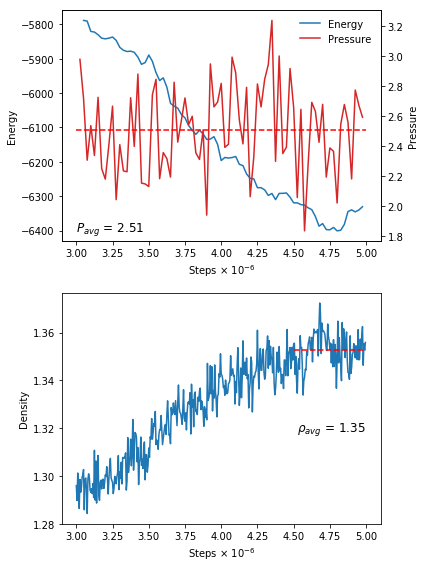

In [84]:
%matplotlib inline




index = np.where(output_steps == 3000000)[0][0]
avg_dict = {}

boxcar_size = 5
for key, value in output_dict.items():
    if key == 'r':
        continue
    else:
        sum_val = 0
        i = 0
        out_list = []
        avg_steps = []
        for val in value[index:]:
            sum_val += val
            if i % boxcar_size == 0:
                if i == 0:
                    i += 1
                    continue
                else:
                    avg_steps.append(output_steps[index + i])
                    out_list.append(sum_val / boxcar_size)
                    sum_val = 0
            
            i += 1
        avg_dict[key] = np.array(out_list)

# boxcar averaging of acceptance rate
avg_steps = np.array(avg_steps) / 1000000


## Plotting of results
plt.figure(figsize=[6,8])
ax_l = plt.subplot(211)
E_plot = plt.plot(avg_steps[1:], avg_dict['E'][1:], label='Energy')

plt.xlabel('Steps × $10^{-6}$')
plt.ylabel('Energy')

ax_r = ax_l.twinx()
P_plot = plt.plot(avg_steps, avg_dict['P'],'C3', label='Pressure')


avgP = avg_dict['P'].mean()
plt.plot([3,5], [avgP, avgP],'r--')
plt.text(3,1.85, '$P_{avg}$ = ' + str(round(avgP, 2)), horizontalalignment='left',
      verticalalignment='center', fontsize=12)

plt.ylabel('Pressure')

lns = E_plot + P_plot
labs = [l.get_label() for l in lns]
ax_l.legend(lns, labs, loc='best', frameon=False)




# plt.subplot(222)



# plt.plot(output_steps[index:], output_dict['Part Accept'][index:], 'C0', label='Particle')
# plt.plot(output_steps[index:], output_dict['Vol Accept'][index:], 'C3', label='Volume')

# plt.ylabel('Acceptance Ratio')
# plt.xlabel('Step')
# plt.legend(loc='best',frameon=False)


# plt.subplot(223)
# plt.plot(output_steps[index:], output_dict['Box Length'][index:])
# plt.ylabel('Box Length')
# plt.xlabel('Step')

plt.subplot(212)

plt.plot(output_steps[index:]/1000000, output_dict['density'][index:])
plt.xlabel('Steps × $10^{-6}$')
plt.ylabel('Density')

rho_avg = output_dict['density'][np.where(output_steps == 4500000)[0][0]:].mean()
print(rho_avg)
plt.plot([4.5,5], [rho_avg, rho_avg],'r--')
plt.text(5,1.32, r'$\rho_{avg}$ = ' + str(round(rho_avg, 2)), horizontalalignment='right',
      verticalalignment='center', fontsize=12)


plt.tight_layout()
plt.savefig('MC-P3.png',dpi=300)


plt.show()   



# Box Visualization
Animates the locations of particles. 
Used primarily for debugging.

<IPython.core.display.Javascript object>


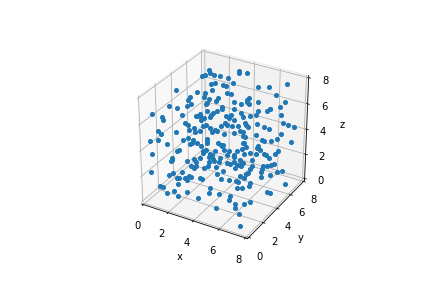

In [11]:
%matplotlib notebook
%matplotlib notebook    # throws fit if magic not called twice for some reason
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d([0,box_size[0]])
ax.set_ylim3d([0,box_size[1]])
ax.set_zlim3d([0,box_size[2]])

x = r_out[:,0,0]
y = r_out[:,1,0]
z = r_out[:,2,0]

def update_graph(frame):
    x = r_out[:,0,frame]
    y = r_out[:,1,frame]
    z = r_out[:,2,frame]
    graph.set_data(x,y)
    graph.set_3d_properties(z)
    print(frame)
    return graph

graph, = ax.plot(x, y, z, linestyle="", marker="o", ms=4)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, n_frames + 1, blit=True, interval=100)
plt.show()

In [25]:
# for key, value in output_dict.items():
#     old_data_dict[key] = np.copy(value)
    
    
# old_steps = np.copy(output_steps)

new_steps = np.append(old_steps, output_steps+1000000)
rold = old_data_dict['r']
print(np.shape(rold))
print(np.shape(output_dict['r']))
new_r = np.append(rold, output_dict['r'], axis=2)
np.shape(new_r)

new_dict = {}

for key, value in old_data_dict.items():
    if key == 'r':
        new_dict['r'] = new_r
    else:
        new_dict[key] = np.append(old_data_dict[key], output_dict[key])
        


(358, 3, 320)
(358, 3, 250)


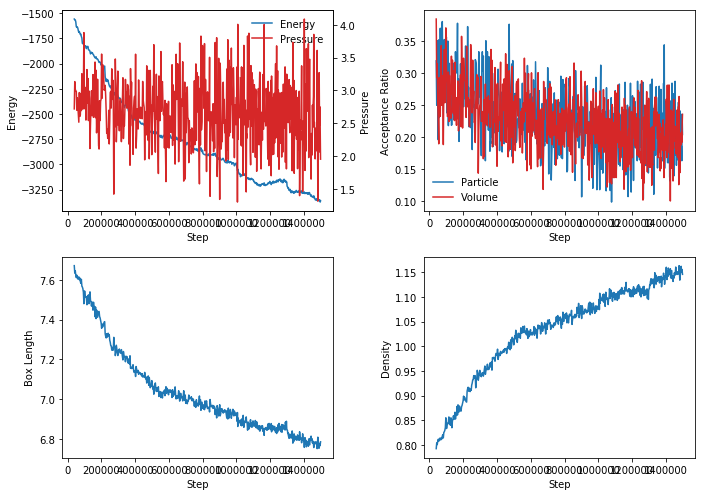

In [27]:
%matplotlib inline

## Plotting of results
plt.figure(figsize=[10,7])
ax_l = plt.subplot(221)
E_plot = plt.plot(new_steps, new_dict['E'], label='Energy')

plt.xlabel('Step')
plt.ylabel('Energy')

ax_r = ax_l.twinx()
P_plot = plt.plot(new_steps, new_dict['P'],'C3', label='Pressure')

plt.ylabel('Pressure')

lns = E_plot + P_plot
labs = [l.get_label() for l in lns]
ax_l.legend(lns, labs, loc='best', frameon=False)



plt.subplot(222)

# # boxcar averaging of acceptance rate
# boxcar_stepsize=10
# sum_part = 0
# sum_vol = 0
# part_box = []
# vol_box = []
# step_box = []
# for i in range(len(pf_part)):
#     sum_part += pf_part[i]
#     sum_vol += pf_vol[i]
#     if i % boxcar_stepsize == 0:
#         part_box.append(sum_part / boxcar_stepsize)
#         vol_box.append(sum_vol / boxcar_stepsize)
#         step_box.append(pf_step[i])
        
#         sum_part = 0
#         sum_vol = 0

plt.plot(new_steps, new_dict['Part Accept'], 'C0', label='Particle')
plt.plot(new_steps, new_dict['Vol Accept'], 'C3', label='Volume')

plt.ylabel('Acceptance Ratio')
plt.xlabel('Step')
plt.legend(loc='best',frameon=False)


plt.subplot(223)
plt.plot(new_steps, new_dict['Box Length'])
plt.ylabel('Box Length')
plt.xlabel('Step')

plt.subplot(224)

plt.plot(new_steps, new_dict['density'])
plt.xlabel('Step')
plt.ylabel('Density')


plt.tight_layout()
# # plt.savefig('MC6.png',dpi=300)


plt.show()   


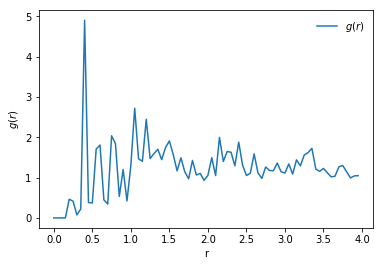

[(0.40290000000000004, array(4.22973249)), (0.5806500000000001, array(1.55346634)), (0.79, array(1.9374226)), (1.05465, array(2.51908744)), (1.2166000000000001, array(2.08668296)), (1.5010000000000001, array(1.56697399)), (2.27125, array(1.67916793)), (3.1955500000000003, array(1.36244584))]


In [92]:
from scipy.interpolate import UnivariateSpline
# box_size = np.array([8,8,8])
avg_density = 1.35
ro = output_dict['r'][:,:,900:]
n_times = np.shape(ro)[2]
n_parts = np.shape(ro)[1]
delta_r = 0.05
max_r = 4
# bins_array = np.zeros(max_r / delta_r)
max_vals = np.arange(0, max_r + delta_r, delta_r)   #doesnt include 4.1
bins_array = np.zeros(len(max_vals)-1)

for m in range(n_times):
    rom = ro[:,:,m]
    for i in range(n_parts-1):
        r_ij_vect = rom[i,:] - rom[(i+1):,:]   
        r_ij_vect -= np.around(r_ij_vect / box_size) * box_size   #pbc

        r_ij = np.sqrt(np.sum(r_ij_vect**2, axis=1))   # magnitude (norm) of r_ij_vect

        k = np.floor(r_ij / delta_r)

        for val in k:
            if val <= (len(bins_array) - 1):
                bins_array[int(val)] += 2


num = bins_array / (n_parts * n_times)
 
i = 0
g = []
for val in max_vals:

    if val == max_vals[0]:
        old_val = val
        continue
    
    
    h = 4 * np.pi * density / 3  * (val**3 - old_val**3)
    
    g.append(num[i] / h)
    old_val = val
    i += 1
    
# Peak finding
dist = max_vals[:-1]
g_spl = UnivariateSpline(dist, g, k=3)
g_spl.set_smoothing_factor(5)


r_arr = np.linspace(dist[0], dist[-1], 1001)

maxima_r = []
maxima_g = []
current_max_val = 0
trending_up = False
for r_val in r_arr:
    g_spl_r = g_spl(r_val)
    if g_spl_r > current_max_val:
        current_max_val = g_spl_r
        trending_up = True
    elif g_spl_r <= current_max_val and trending_up:
        maxima_r.append(r_val)
        maxima_g.append(g_spl(r_val))
        trending_up = False
    elif g_spl_r < current_max_val:
        trending_up = False
        current_max_val= g_spl_r

max_peak = maxima_g.index(max(maxima_g))
maxima_r = maxima_r[max_peak:]
maxima_g = maxima_g[max_peak:]
        
    
plt.figure()
plt.subplot(111)
plt.plot(dist, g, label='$g(r)$')
# plt.plot(dist, g_spl(dist), 'k',lw=0.7, label='Spline Fit')
# plt.plot(maxima_r, maxima_g, 's', c='C3',label='Maxima')
plt.xlabel('r')
plt.ylabel('$g(r)$')
plt.legend(frameon=False)
plt.savefig('MC-gr-1.png', dpi=300)
plt.show()

print(list(zip(maxima_r, maxima_g)))


In [85]:
box_size

array([7.23397694, 7.23397694, 7.23397694])

In [29]:
import time

start = time.time()
x = 0
for n in range(10000000):
    x +=1
end = time.time()
end - start

1.210273265838623

In [43]:
np.where(output_steps == 4000000)[0][0]

800